In [1]:
%matplotlib inline
import re
import pandas as pd
import random
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn import decomposition, preprocessing
from sklearn.decomposition import FactorAnalysis, PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from IPython.display import display
import matplotlib.cm as cm

plt.rcParams['figure.figsize'] = (12.0, 10.0)

In [2]:
df = pd.read_csv('../datapackage/quiho/results.csv')

In [3]:
df.columns

Index(['giturl', 'commit', 'user', 'timestamp', 'benchmark', 'machine',
       'repetition', 'test', 'result'],
      dtype='object')

In [4]:
df.benchmark.unique()

array(['stressng', 'ssca', 'hpccg', 'scikit-learn', 'redisbench'], dtype=object)

In [5]:
df.test.unique()

array(['af-alg', 'atomic', 'bigheap', 'brk', 'bsearch', 'cache', 'cpu',
       'crypt', 'full', 'heapsort', 'hsearch', 'icache', 'lockbus',
       'longjmp', 'lsearch', 'malloc', 'matrix', 'memcpy', 'mincore',
       'mmap', 'mremap', 'msync', 'nop', nan, 'numa', 'oom-pipe', 'opcode',
       'qsort', 'remap', 'resources', 'rmap', 'shm', 'shm-sysv', 'stack',
       'stackmmap', 'str', 'stream', 'tsearch', 'vecmath', 'vm', 'vm-rw',
       'vm-splice', 'zero', 'ssca', 'hpccg', 'sklearn', 'SET', 'GET',
       'LPUSH', 'LPOP'], dtype=object)

In [6]:
df.machine.unique()

array(['c220g1.quiho.schedock-PG0.wisc.cloudlab.us',
       'c220g2.quiho.schedock-PG0.wisc.cloudlab.us',
       'c6220.quiho.schedock-PG0.apt.emulab.net',
       'c6320.quiho.schedock-PG0.clemson.cloudlab.us',
       'c8220.quiho.schedock-PG0.clemson.cloudlab.us',
       'd2100.quiho.Schedock.emulab.net', 'd430.quiho.Schedock.emulab.net',
       'd530.quiho.Schedock.emulab.net', 'd710.quiho.Schedock.emulab.net',
       'd820.quiho.Schedock.emulab.net',
       'dl360.quiho.emulab-net.utahddc.geniracks.net',
       'dwill.soe.ucsc.edu', 'issdm-0',
       'm510.quiho.schedock-PG0.utah.cloudlab.us',
       'pc2400.quiho.emulab-net.uky.emulab.net',
       'pc3000.quiho.Schedock.emulab.net',
       'pc3300.quiho.emulab-net.uky.emulab.net',
       'pc3400.quiho.emulab-net.uky.emulab.net',
       'pc3500.quiho.emulab-net.uky.emulab.net',
       'r320.quiho.schedock-PG0.apt.emulab.net', 'scruffy.soe.ucsc.edu'], dtype=object)

In [7]:
df.sample(5).T

,2950,589,850,329,2604
giturl,git@github.com:ivotron/quiho-popper,git@github.com:ivotron/quiho-popper,git@github.com:ivotron/quiho-popper,git@github.com:ivotron/quiho-popper,git@github.com:ivotron/quiho-popper
commit,d46d579,d46d579,d46d579,d46d579,d46d579
user,ivo,ivo,ivo,ivo,ivo
timestamp,1512873230,1512873230,1512873230,1512873230,1512873230
benchmark,redisbench,stressng,stressng,stressng,stressng
machine,m510.quiho.schedock-PG0.utah.cloudlab.us,c8220.quiho.schedock-PG0.clemson.cloudlab.us,d430.quiho.Schedock.emulab.net,c6220.quiho.schedock-PG0.apt.emulab.net,scruffy.soe.ucsc.edu
repetition,1,2,2,2,3
test,LPOP,rmap,stack,remap,numa
result,461894,354.296,0,315.72,116.098


In [8]:
# treat every repetition as a new data point
df['machine+repetition'] = df.apply(lambda x: x['machine'] + '-' + str(x['repetition']), axis=1) 

In [9]:
len(df.index)

3043

In [10]:
df.dropna(inplace=True)

In [11]:
len(df.index)

2982

In [12]:
# what we use for feature vectors
df.query('benchmark == "stressng"')['test'].unique()

array(['af-alg', 'atomic', 'bigheap', 'brk', 'bsearch', 'cache', 'cpu',
       'crypt', 'full', 'heapsort', 'hsearch', 'icache', 'lockbus',
       'longjmp', 'lsearch', 'malloc', 'matrix', 'memcpy', 'mincore',
       'mmap', 'mremap', 'msync', 'nop', 'numa', 'oom-pipe', 'opcode',
       'qsort', 'remap', 'resources', 'rmap', 'shm', 'shm-sysv', 'stack',
       'stackmmap', 'str', 'stream', 'tsearch', 'vecmath', 'vm', 'vm-rw',
       'vm-splice', 'zero'], dtype=object)

In [13]:
# what we can use to build models (apps whose performance we can learn)
apps = df.query('benchmark != "stressng"')['test'].unique()
apps

array(['ssca', 'hpccg', 'sklearn', 'SET', 'GET', 'LPUSH', 'LPOP'], dtype=object)

In [14]:
# let's look first at properties of the feature vectors
data = df.pivot_table(index=["machine+repetition","test"], values=['result'], fill_value=0, aggfunc=np.mean).unstack().reset_index()
feature_columns = list(df.query('benchmark == "stressng"')['test'].unique())

# flatten the index
cols = data.columns.get_level_values(1).values
cols[0] = 'machine+repetition'
data.columns = cols
data.dropna(inplace=True)

In [15]:
def plot_corrmatrix(dataf):
    corrmatrix = dataf.corr()
    mask = np.zeros_like(corrmatrix)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(corrmatrix, mask=mask,
                xticklabels=corrmatrix.columns.values,
                yticklabels=corrmatrix.columns.values)
    return corrmatrix

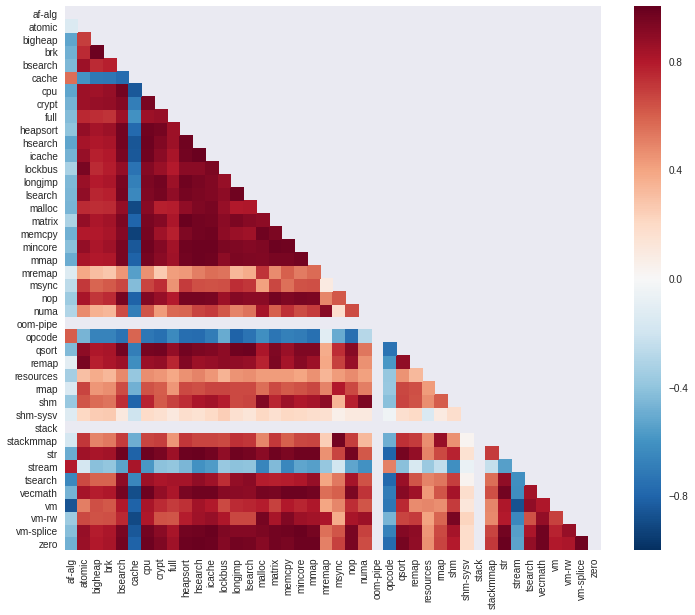

In [16]:
corr_matrix = plot_corrmatrix(data[feature_columns])
plt.savefig('figures/corrmatrix.png', dpi=300, bbox_inches='tight')

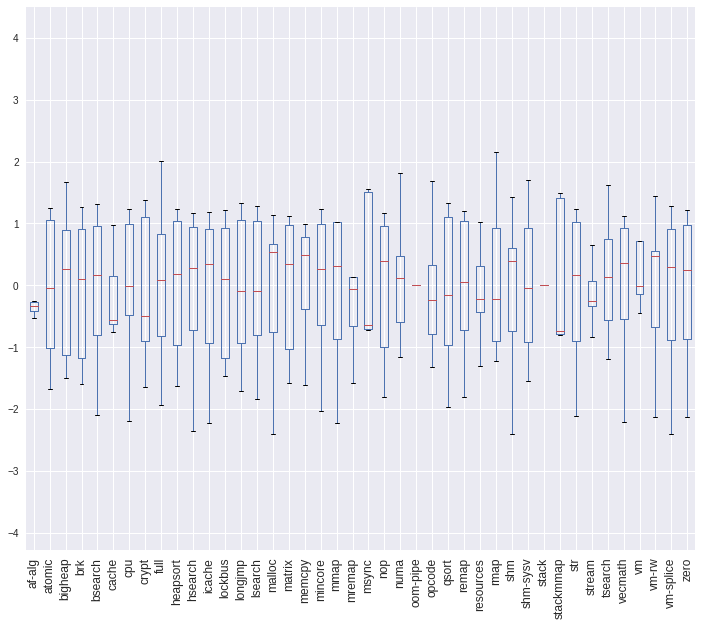

In [17]:
# now we'll look at the variability across all machines
rs = np.random.RandomState(1)
z_scaler = StandardScaler()
z_data = z_scaler.fit_transform(data[feature_columns])

dff = pd.DataFrame(z_data, columns=feature_columns)

dff.boxplot()
_ = plt.xticks(rotation=90)
plt.savefig('figures/stressng_variability.png', dpi=300, bbox_inches='tight')


In [18]:
# gradient boosting regression
# taken from http://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html
# extended to normalize data

rs = np.random.RandomState(1)
z_scaler = StandardScaler()

def plot_importance(data, feats, apps):
    for b in apps:
        # normalize data
        z_data = z_scaler.fit_transform(data[feats])
        
        # fit using random forest regressor
        params = {'n_estimators': 1000, 'max_depth': 4, 'min_samples_split': 2,
                  'learning_rate': 0.01, 'loss': 'ls'}
        regr = GradientBoostingRegressor(**params)
        regr.fit(z_data, data[b])

        # Plot feature importance
        feature_importance = regr.feature_importances_
        # make importances relative to max importance
        feature_importance = 100.0 * (feature_importance / feature_importance.max())
        sorted_idx = np.argsort(feature_importance)
        pos = np.arange(sorted_idx.shape[0]) + .5
        plt.barh(pos, feature_importance[sorted_idx], align='center')
        plt.yticks(pos, np.array(feats)[sorted_idx])
        plt.xlabel('Relative Importance')
        plt.title(b)
        plt.show()
        plt.savefig('figures/{}.png'.format(b), dpi=300, bbox_inches='tight')

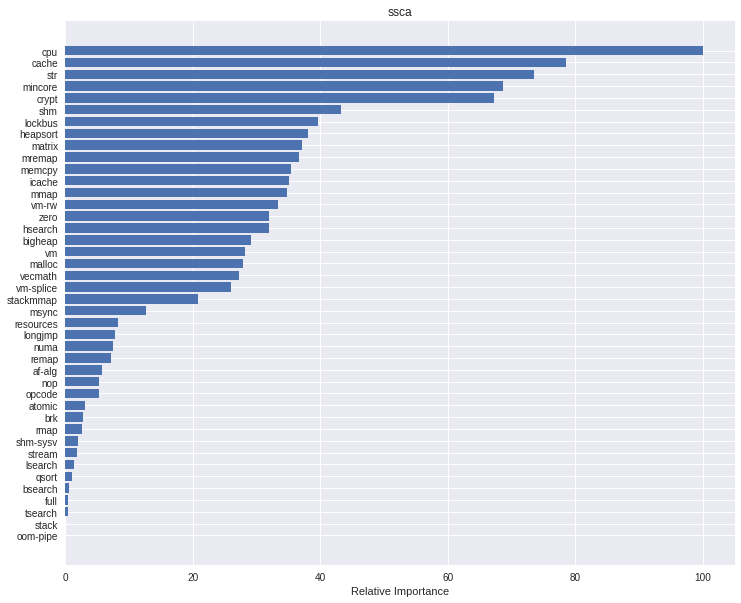

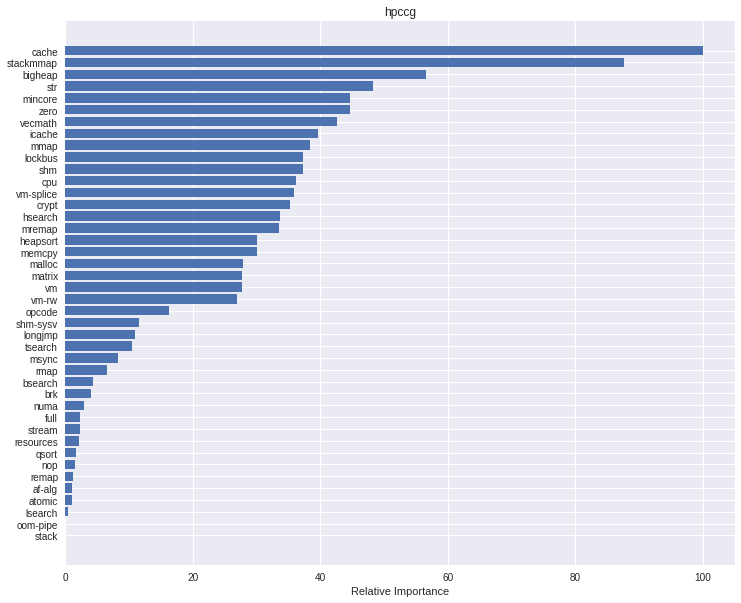

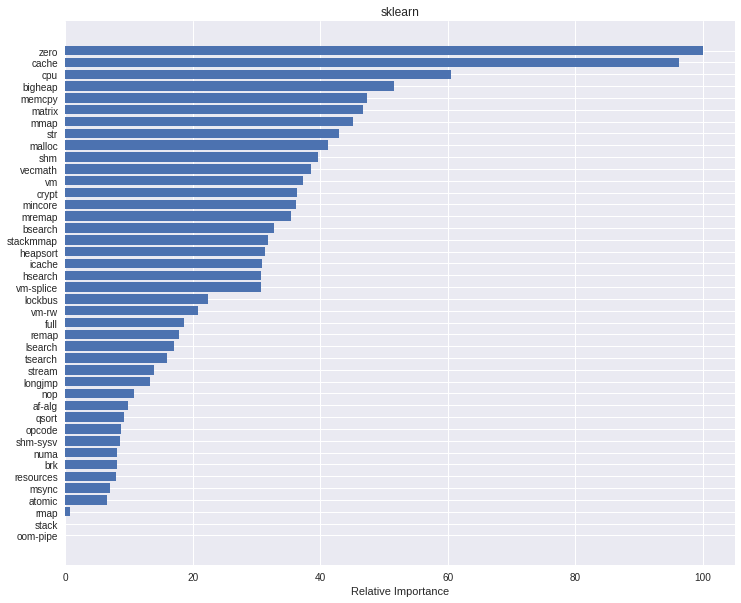

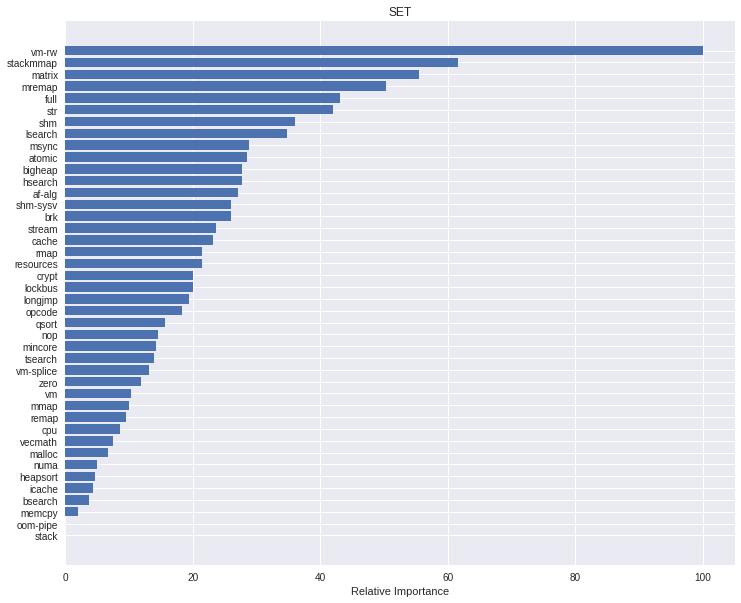

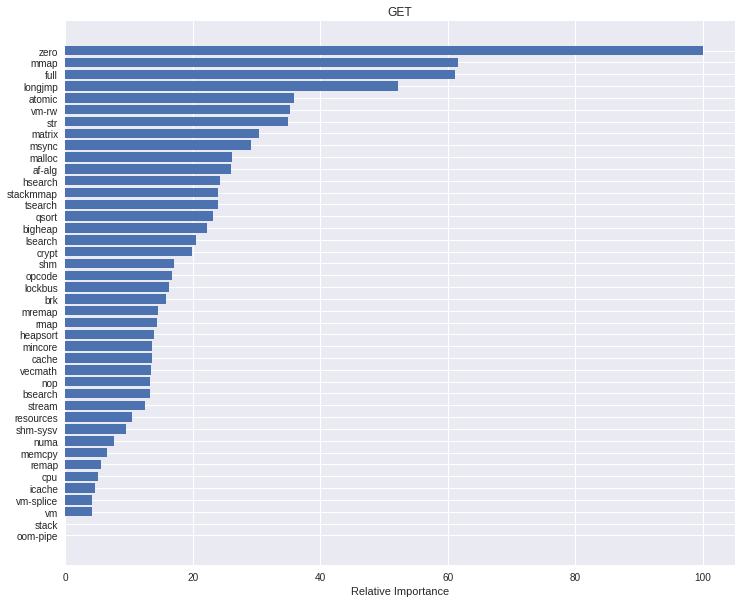

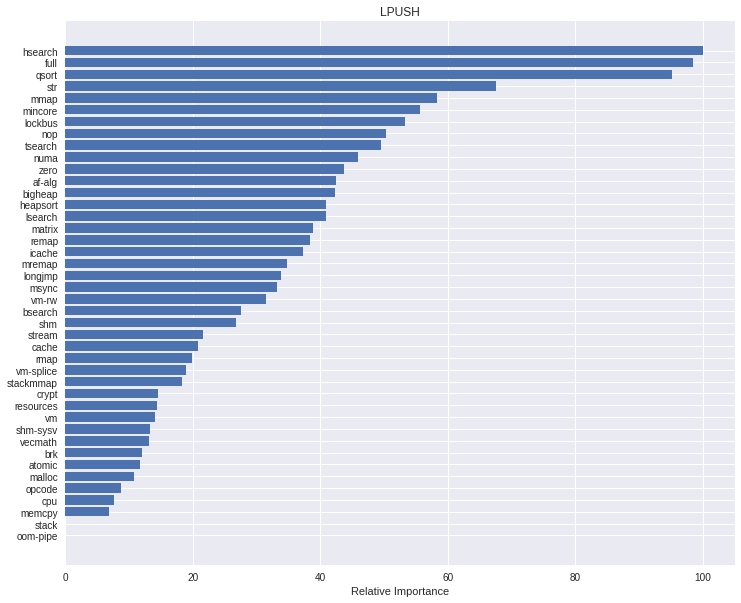

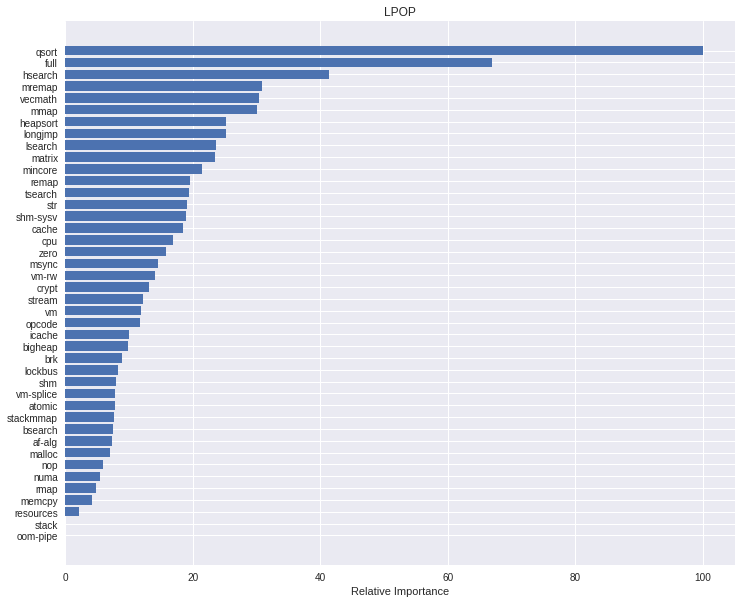

In [19]:
plot_importance(data, feature_columns, apps)